In [1]:
import meshio
import numpy as np
import load_from_snapshot
from matplotlib import pyplot as plt
import glob
import h5py
from scipy.interpolate import griddata
%pylab
from meshoid import Meshoid
from load_from_snapshot import load_from_snapshot
%matplotlib inline
import matplotlib.colors as colors
from numba import jit

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
filename = 'testsnap.hdf5' 
F = h5py.File(filename, "r")
Coordinates = np.array(F["Point"]["Positions"])
Velocities = np.array(F["Cell"]["Velocities"])
F.close()
#arr2 = np.concatenate((Coordinates,Velocities),axis=1)
#arrfinal = np.unique(arr2, axis=0)

#We load our data. Arrfinal is used for the process of creating slices.

In [190]:
#Positions is a grid.
#Cubes returns the indicies of the Coordinates, which can be used to assign them to cubes. 
import numpy as np
from scipy.spatial import KDTree
CubeLength = 0.1
numR = int((Coordinates[:,0].max() - Coordinates[:,0].min())/CubeLength)
numT = int((Coordinates[:,1].max() - Coordinates[:,1].min())/CubeLength)
numZ = int((Coordinates[:,2].max() - Coordinates[:,2].min())/CubeLength)

r_i = np.linspace(Coordinates[:,0].min(),Coordinates[:,0].max(),numR)
t_i = np.linspace(Coordinates[:,1].min(),Coordinates[:,1].max(),numT)
z_i = np.linspace(Coordinates[:,2].min(),Coordinates[:,2].max(),numZ)

A, B, C = np.meshgrid(r_i, t_i, z_i)
positions = np.vstack([A.ravel(), B.ravel(), C.ravel()]).T
T = KDTree(Coordinates)
Cubes = np.array(T.query_ball_point(positions, (CubeLength/2), eps=0, p=np.inf, workers=8)); print(np.shape(Cubes))
#Returns nearest-neighbor search for cubes of volume CubeLength**3
#Steps:
#1. We created a grid with Positions. 
#2. We now need to populate Positions with the right velocities (tensors) based on the indicies given by Cubes[1].
#3. We then take the average along an axis and return with our final visualization.

(49600,)


In [191]:
#For each defined cell of the grid positions, we take the neighbors (as found in cubes) and find
#an individual value for each and every grid position. This should return an array with a unique value
#for grid position of a velocity. Then, we can easily find the averages along an axis
#VList = []
#@jit(nopython=True)
def VelAverage(neighbors):
    VList = []
    for n in neighbors:
        VList.append(np.average(Velocities[n],axis = 0))
    return VList    
VFinal = np.array(VelAverage(Cubes))

In [192]:
print(np.shape(VFinal))
print(np.shape(positions))

(49600, 3)
(49600, 3)


In [193]:
#Only run to check for NaN if desired.
import math
for n in VFinal[:,2]:
    if(math.isnan(n)):
        print(n)

In [194]:
r_i = np.linspace(Coordinates[:,0].min(),Coordinates[:,0].max(),1000)
z_i = np.linspace(-2.0,2.0,2000)
A, B = np.meshgrid(r_i,z_i)
GridFinal = np.concatenate((positions,VFinal),axis=1)
#New approach. Create slices from data.
arrTheta = np.empty((numR*numZ, len(GridFinal[1])))
for t in np.unique(GridFinal[:,1]):
    id1 = GridFinal[:,1]==t
    slice = GridFinal[id1]
    arrTheta = np.dstack([arrTheta, slice])
arrTheta = arrTheta[:,:,1:] #Excludes the empty array we created.
#We now crunch theta across the theta axis.
crunchTheta = np.nanmean(arrTheta, axis=2)
r_avg1 = crunchTheta[:,0]
t_avg1 = crunchTheta[:,1]
z_avg1 = crunchTheta[:,2]
vr_avg1 = crunchTheta[:,3]
vt_avg1 = crunchTheta[:,4]
vz_avg1 = crunchTheta[:,5]
print(arrTheta.shape)

(800, 6, 62)


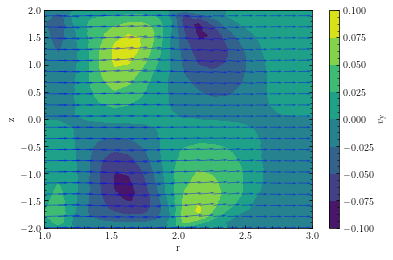

In [195]:
m = -0.5
n=2

QV = plt.quiver(r_avg1[::n], z_avg1[::n], (10**m)*vr_avg1[::n], (10**m)*vz_avg1[::n], color='b', units='xy', scale=1, alpha=0.5)
Z = griddata((r_avg1,z_avg1),vz_avg1,(A,B))
plt.contourf(A,B,Z, zorder=-1,); plt.colorbar(label=r"$v_{\rm t}$"); plt.xlabel("r");plt.ylabel("z");
#plt.legend([QV], [r"$v_{\rm r}, v_{\rm z}$"], loc='upper right', frameon=True)
plt.savefig("/home/hlane/yt-conda/PPPL/data/paraviewed/plots/meshoid_Vmap.pdf",bbox_inches='tight')

In [ ]:
for n in vz_avg1:
    if np.isnan(n):
        print(n)

In [ ]:
"""Below here is a bunch of failed attempts to produce the above solution."""

#axis = 2 #Axis = 0, theta is right. Axis = 1, z is right. Axis = 2, radius is right
#axis2 = 2
#Perform a series of reshapes to take the average. Note that there is an unintuitive usage of axis=0.
#r = positions[:,0]
#t = positions[:,1]
#z = positions[:,2]

#vr = VFinal[:,0]
#vt = VFinal[:,1]
#vz = VFinal[:,2]
#r = np.reshape(positions[:,0], (numR, numT, numZ)); print(r.shape)
#t = np.reshape(positions[:,1], (numR, numT, numZ)); print(t.shape)
#z = np.reshape(positions[:,2], (numR, numT, numZ)); print(z.shape)
#vr = np.reshape(VFinal[:,0], (numR, numT, numZ)); print(vr.shape)
#vt = np.reshape(VFinal[:,1], (numR, numT, numZ)); print(vt.shape)
#vz = np.reshape(VFinal[:,2], (numR, numT, numZ)); print(vz.shape)
#positions2 = np.reshape(positions, numR)

#print(arrTheta.shape)        #M1 = Meshoid(np.unique(slice1[:,[0,1,2]],axis=0), n_jobs=8, boxsize=None)
#print(arrTheta[:,:,0].shape)
#print(arrTheta[:,:,1])

#for radius in np.unique(positions[:,0]):
#    for height in np.unique(positions[:,2]):
#
#        id1 = radius == positions[:,0]
#        id2 = radius == positions[:,2]
#        id3 = id1*id2
#        r_avg = np.nanmean(r[id3])
#print(positions)
#positions_avg = np.nanmean(positions, axis = axis); print(positions_avg.shape)
"""
r_avg = np.nanmean(r, axis = axis); print(r_avg.shape)
t_avg = np.nanmean(t, axis = axis); print(t_avg.shape)
z_avg = np.nanmean(z, axis = axis); print(z_avg.shape)
vr_avg = np.nanmean(vr, axis = axis); print(vr_avg.shape)
vt_avg = np.nanmean(vt, axis = axis); print(vt_avg.shape)
vz_avg = np.nanmean(vz, axis = axis); print(vz_avg.shape)

r_avg1 = np.reshape(r_avg, (len(r_avg)*len(r_avg[1]))); print(r_avg1.shape)
t_avg1 = np.reshape(t_avg, (len(t_avg)*len(t_avg[1]))); print(t_avg1.shape)
z_avg1 = np.reshape(z_avg, (len(z_avg)*len(z_avg[1]))); print(z_avg1.shape)
vr_avg1 = np.reshape(vr_avg, (len(vr_avg)*len(vr_avg[1]))); print(vr_avg1.shape)
vt_avg1 = np.reshape(vt_avg, (len(vt_avg)*len(vt_avg[1]))); print(vt_avg1.shape)
vz_avg1 = np.reshape(vz_avg, (len(vz_avg)*len(vz_avg[1]))); print(vz_avg1.shape)"""

In [ ]:
a=0
for t in np.unique(arrfinal[:,1]):
    id1 = arrfinal[:,1]==t
    if(a==0):
        slice1 = arrfinal[id1]
        #M1 = Meshoid(np.unique(slice1[:,[0,1,2]],axis=0), n_jobs=8, boxsize=None)

    if(a==16):
        slice2 = arrfinal[id1]
        #M2 = Meshoid(np.unique(slice2[:,[0,1,2]],axis=0), n_jobs=8, boxsize=None)

        break
    a+=1

    #M = Meshoid(np.unique(Pos[id1],axis=0), n_jobs=8, boxsize=None)

In [ ]:
slice = slice1
r = slice[:,0]
t = slice[:,1]
z = slice[:,2]
vr = slice[:,3]
vt = slice[:,4]
vz = slice[:,5]
m = 0


In [ ]:
r_i = np.linspace(Coordinates[:,0].min(),Coordinates[:,0].max(),128)
z_i = np.linspace(-2.0,2.0,128)
A, B = np.meshgrid(r_i,z_i)
m = -0.5
n = 56
#QV = plt.quiver(r[::n], z[::n], (10**m)*vr[::n], (10**m)*vz[::n], color='b', units='xy', scale=1, alpha=0.5)
Z = griddata((r,z),vt,(A,B))
plt.contourf(A,B,Z, zorder=-1,); plt.colorbar(label=r"$v_{\rm y}$"); plt.xlabel("x");plt.ylabel("z");
#plt.legend([QV], [r"$v_{\rm r}, v_{\rm z}$"], loc='upper right', frameon=True)
plt.savefig("/home/hlane/yt-conda/PPPL/data/paraviewed/plots/meshoid_Vmap.pdf",bbox_inches='tight')

In [ ]:
hsml = np.full((len(np.unique(Coordinates,axis=0)),), 0.8)

In [ ]:
M = Meshoid(np.unique(Coordinates,axis=0), hsml=hsml,  n_jobs=8, boxsize=None,)

In [ ]:
vx_avg = M.ProjectedAverage(f=np.unique(Velocities[:,0], axis=0), plane='y', res=64)
vy_avg = M.ProjectedAverage(f=np.unique(Velocities[:,1], axis=0), plane='y', res=64)
vz_avg = M.ProjectedAverage(f=np.unique(Velocities[:,2], axis=0), plane='y', res=64)

In [ ]:
hsml = []
plt.imshow(vx_avg)
plt.show()
plt.imshow(vy_avg)
plt.show()
plt.imshow(vz_avg)
plt.show()


In [ ]:
#vx_avg = M.ProjectedAverage(f=np.unique(Velocities[:,0], axis=0), plane='y', res=100)


In [ ]:
res = 64
r_i = np.linspace(Coordinates[:,0].min(),Coordinates[:,0].max(),64)
z_i = np.linspace(-2.0,2.0,64)
A, B = np.meshgrid(r_i,z_i)
fig, ax = plt.subplots(figsize=(6,6))
p = ax.pcolormesh(A, B, vy_avg, )#norm=colors.LogNorm(vmin=.1,vmax=1e3))
ax.set_aspect('equal')
fig.colorbar(p,label=r"$\Sigma_{gas}$ $(\rm M_\odot\,pc^{-2})$")
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Z (kpc)")
plt.show()

In [ ]:
plt.scatter(r,z)

In [ ]:
#array2 = np.empty((80601, 5))

r = Pos[:,0]
t = Pos[:,1]
z = Pos[:,2]
vr = Vel[:,0]
vt = Vel[:,1]
vz = Vel[:,2]

#if (r_0[np.isnan(r_0)]): print(str(r_0) + " x: " + str(x) + " y: " + str(y))
#data = np.c_[r_0, z, vt, vr, vz]
#array2 = np.array([r, t, z, vr, vt, vz]).T
#print(np.shape(array2))
#finale_file = np.mean(Vel, axis=2)
#final_file = finale_file *(24**-1)

In [ ]:
vr_avg = M.ProjectedAverage(f=np.unique(Vel[:,0], axis=0), plane='y')
vt_avg = M.ProjectedAverage(f=np.unique(Vel[:,1], axis=0), plane='y')
vz_avg = M.ProjectedAverage(f=np.unique(Vel[:,2], axis=0), plane='y')
#vr = np.reshape(vr_avg, (len(vr_avg)**2,))
#vt = np.reshape(vt_avg, (len(vt_avg)**2,))
#vz = np.reshape(vz_avg, (len(vz_avg)**2,))

In [ ]:
print(vr_avg)

In [ ]:
print(np.shape(vt_avg))

In [ ]:
vtot = np.sqrt(vr_avg**2 + vt_avg**2 + vz_avg **2)

In [ ]:
#M.InterpToGrid(vr_avg)

In [ ]:
#vr = np.reshape(vr_avg, (len(vr_avg)**2,))
#vt = np.reshape(vt_avg, (len(vt_avg)**2,))
#vz = np.reshape(vz_avg, (len(vz_avg)**2,))

In [ ]:
r = np.unique(Pos[:,0],axis=0)
t = np.unique(Pos[:,1],axis=0)
z = np.unique(Pos[:,2],axis=0)
n = 10000
m = 0

In [ ]:
r_i = np.linspace(Pos[:,0].min(),Pos[:,0].max(),128)
z_i = np.linspace(-2.0,2.0,128)
A, B = np.meshgrid(r_i,z_i)

In [ ]:
plt.imshow(vtot)

In [ ]:
res = 128
r_i = np.linspace(Pos[:,0].min(),Pos[:,0].max(),128)
z_i = np.linspace(-2.0,2.0,128)
A, B = np.meshgrid(r_i,z_i)
fig, ax = plt.subplots(figsize=(6,6))
sigma_gas_msun_pc2 = M.SurfaceDensity(M.m,center=np.array([0,0,0]),size=40.,res=res)*1e4
p = ax.pcolormesh(A, B, sigma_gas_msun_pc2, norm=colors.LogNorm(vmin=.1,vmax=1e3))
ax.set_aspect('equal')
fig.colorbar(p,label=r"$\Sigma_{gas}$ $(\rm M_\odot\,pc^{-2})$")
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()

In [ ]:
m = -0.5
#QV = plt.quiver(r[::n], z[::n], (10**m)*vr[::n], (10**m)*vz[::n], color='b', units='xy', scale=1, alpha=0.5)
Z = griddata((r,z),vz,(A,B))
plt.contourf(A,B,Z, zorder=-1,); plt.colorbar(label=r"$v_{\rm t}$"); plt.xlabel("r");plt.ylabel("z");
plt.legend([QV], [r"$v_{\rm r}, v_{\rm z}$"], loc='upper right', frameon=True)
plt.savefig("/home/hlane/yt-conda/PPPL/data/paraviewed/plots/meshoid_Vmap.pdf",bbox_inches='tight')

In [ ]:
r_i = np.linspace(Pos[:,0].min(),Pos[:,0].max(),128)
z_i = np.linspace(-2.0,2.0,128)
A, B = np.meshgrid(r_i,z_i)
res = 128
fig, ax = plt.subplots(figsize=(6,6))
p = ax.pcolormesh(A, B, vz_avg,) #norm=colors.LogNorm(vmin=.1,vmax=1e3))
#ax.set_aspect('equal')
fig.colorbar(p,label="vz")
ax.set_xlabel("r")
ax.set_ylabel("z")
plt.show()

In [ ]:
plt.plot(vt_avg)

In [ ]:
n=10
print(r.min())
plt.plot(r[::n],z[::n])
print(str(t.min()) + " and " + str(t.max()))

In [ ]:
plt.plot(x,y)

In [ ]:
coord = np.array(coords)
print(np.min(coord[::,0])) #r
print(np.min(coord[::,1])) #t?
print(np.min(coord[::,2])) #z


In [ ]:
cells = data.__dict__
print(cells)

In [ ]:

print(np.shape(cellsdata['vel']))
data = meshio.read(f)
print(data)

In [ ]:
Files = glob.glob("data/rawdata/Velocity_proc_*_it_0.vtu")
coordinates = np.empty([0,3])
velocities = np.empty([0,3])
for f in Files:
    
    data = meshio.read(f)
    coordinates_0 = data.points
    coordinates = np.concatenate((coordinates, coordinates_0))    
    
    cellsdata = data.point_data
    velocities_0 = cellsdata['vel']
    velocities = np.concatenate((velocities, velocities_0))   


In [ ]:
filename = 'testsnap.hdf5' 
F=h5py.File(filename, 'w')
F.create_group("Point")
F["Point"].create_dataset("Positions", data = (r,t,z))
F.close()

In [ ]:
%pylab
from meshoid import Meshoid
from load_from_snapshot import load_from_snapshot
%matplotlib inline

In [ ]:
pos = coordinates
v = velocities
center = np.median(pos,axis=0)
pos -= center
print(len(pos))

mass = np.empty([13285566])
hsml = 0.01
M = Meshoid(pos, mass, hsml)


In [ ]:
M.D(pos) 


In [ ]:
__class__         __gt__             __reduce__         cell_data_dict     info
__delattr__       __hash__           __reduce_ex__      cell_sets          int_data_to_sets
__dict__          __init__           __repr__           cell_sets_dict     point_data
__dir__           __init_subclass__  __setattr__        cells              point_sets
__doc__           __le__             __sizeof__         cells_dict         points
__eq__            __lt__             __str__            field_data         prune
__format__        __module__         __subclasshook__   get_cell_data      read
__ge__            __ne__             __weakref__        get_cells_type     sets_to_int_data
__getattribute__  __new__            cell_data          gmsh_periodic      write